# Practice: Dealing with texts using CNN
_Reference: Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

## About the challenge
For starters, let's download and unpack the data.

You can also get it from [Yandex.Disk](https://yadi.sk/d/vVEOWPFY3NruT7) or [the competition page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [1]:
!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar xzf Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   145    0   145    0     0    436      0 --:--:-- --:--:-- --:--:--   436
100   342  100   342    0     0    475      0 --:--:-- --:--:-- --:--:--   475
100  119M  100  119M    0     0  20.3M      0  0:00:05  0:00:05 --:--:-- 30.4M


In [15]:
import pandas as pd


data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

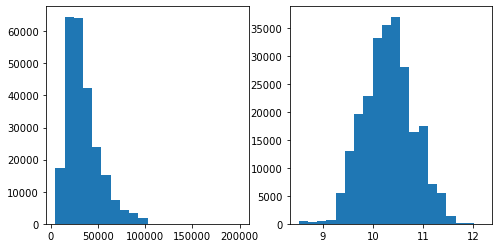

In [16]:
import matplotlib.pyplot as plt
import numpy as np


data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20)

plt.show()

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [17]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna("NaN")
data[text_columns] = data[text_columns].fillna("NaN")

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
125885,69994072,Interim HR Manager,Main Accountabilities: Partner with the local...,"Slough, Berkshire Berkshire South East",Slough,NaN,contract,hyphen,HR & Recruitment Jobs,45000 - 55000 per annum,50000,totaljobs.com,10.819798
184658,71658857,HR Manager Regional Role,My client a leading a retailer is seeking an e...,"North West England, England",North West England,NaN,NaN,Oakleaf Partnership,HR & Recruitment Jobs,40000 - 45000 per annum + Benefits + car allow...,42500,Personneltoday Jobs,10.657283
68287,68783693,GRADUATE SALES EXECUTIVE / GRADUATE SALES TRAINEE,GRADUATE SALES EXECUTIVE / GRADUATE SALES TRAI...,"Warrington, Cheshire Cheshire North West",Warrington,NaN,NaN,BMS Sales Specialists LLP,Sales Jobs,"22000 per annum + bonus, mobile, benefits",22000,salestarget.co.uk,9.998843


## Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [18]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [19]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()

def normalize(text):
    tokens = tokenizer.tokenize(text.lower())
    return ' '.join(tokens)
# Lowercase and tokenize titles and descriptions (text_columns).
# Store items as space-separated strings of tokens.
data[text_columns] = data[text_columns].applymap(normalize)

In [20]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [21]:
from collections import Counter
from tqdm.auto import tqdm



# Count how many times does each token occur in both "Title" and "FullDescription".
# Build a dictionary { token -> count }.
# Hint: you may or may not want to use collections.Counter
token_counts = Counter()
for row in data[text_columns].values.flatten():
    token_counts.update(row.split(' '))

In [22]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Let's see how many words are there for each count.

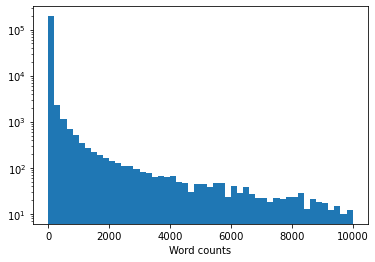

In [23]:
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

Now we will filter tokens a list of all tokens that occur at least 10 times.

In [24]:
min_count = 10

# We shall only consider tokens that had at least min_count occurences.
# Create a list of such tokens.
tokens = [token for token, counts in token_counts.items() if counts >= min_count]

In [25]:
len(tokens)

34156

In [26]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token to it's index in `tokens`.

In [27]:
# YOUR CODE HERE
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [28]:
assert isinstance(token_to_idx, dict)
assert len(token_to_idx) == len(tokens)
for tok in tokens:
    assert tokens[token_to_idx[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [29]:
UNK_IDX = token_to_idx[UNK]
PAD_IDX = token_to_idx[PAD]


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = [seq.split(" ") for seq in sequences]

    sequences_max_len = max(len(seq) for seq in sequences)
    if max_len is None:
        max_len = sequences_max_len
    else:
        max_len = min(sequences_max_len, max_len)

    matrix = np.full((len(sequences), max_len), PAD_IDX)
    for i, seq in enumerate(sequences):
        for j, token in enumerate(seq):
            if j >= max_len:
                break

            matrix[i, j] = token_to_idx.get(token, UNK_IDX)

    return matrix

In [30]:
print("Lines:")
print("\n".join(data["Title"][::100000].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [31]:
from sklearn.feature_extraction import DictVectorizer


# We only consider top-1k most frequent companies to minimize memory usage
company_counts = Counter(data["Company"])
top_companies = set(name for name, count in company_counts.most_common(1000))
data["Company"] = data["Company"].apply(
    lambda company: company if company in top_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1));

## The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [32]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [33]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(matrix, keep_prob, replace_with=UNK_IDX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prob, 1 - keep_prob])
    dropout_mask &= matrix != PAD_IDX
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [34]:
example_batch = make_batch(data_train[:3], max_len=10)
print("Example batch:")
print(example_batch)
print("FullDescription shape:", example_batch["FullDescription"].shape)

Example batch:
{'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
       [29239,   197, 19175, 20042, 15554, 23162,  4051],
       [10609, 30412, 17746,    33,  8705, 29157,    65]]), 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
        32939],
       [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
           82],
       [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
        17746]]), 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}
FullDescription shape: (3, 10)


In [35]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

To generate minibatches we will use simple pyton generator.

In [36]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

## Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [40]:
import torch

In [41]:
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# Initially, our FullDescription has a shape [batch_size, seq_len].
# After an Embedding layer shape will be [batch_size, seq_len, embedding_size].
# However, Conv1d layer expects batches of shape [batch_size, embedding_size, seq_len].
# We will use this layer to fix this misunderstanding.
class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [42]:
n_tokens = len(token_to_idx)
n_cat_features = len(categorical_vectorizer.vocabulary_)
hid_size = 64
n_maximums = 2

simple_model = nn.Sequential(
    nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size),
    Reorder(),
    
    nn.Conv1d(in_channels=hid_size,
              out_channels=2*hid_size,
              kernel_size=3),
    nn.ReLU(),
    
    nn.Conv1d(in_channels=2*hid_size,
              out_channels=2*hid_size,
              kernel_size=3),
    nn.ReLU(),
    
    nn.BatchNorm1d(hid_size*2),
    
    nn.AdaptiveMaxPool1d(n_maximums),
    nn.Flatten(),
    nn.Linear(hid_size*2 * n_maximums, 1)
)

##### Debug start

In [43]:
example_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)

In [44]:
batch['FullDescription'].shape

(3, 362)

In [ ]:
b = simple_model(torch.tensor(batch['FullDescription'], dtype=torch.long))

In [ ]:
b.shape

torch.Size([3, 1])

##### Degub end

__Remember!__ We are working with regression problem and predicting only one number.

In [ ]:
# Check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch["FullDescription"], dtype=torch.long))

tensor([[-1.6327],
        [-0.2792],
        [ 2.8286]], grad_fn=<AddmmBackward0>)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

And now simple training pipeline:

In [17]:
from IPython.display import clear_output

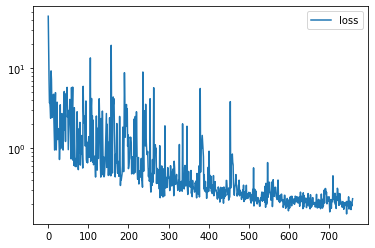

In [ ]:
from IPython.display import clear_output


epochs = 1
model = simple_model
model.to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss().to(device)

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        target = torch.tensor(target, device=device)

        predictions = model(batch)
        predictions = predictions.flatten()

        opt.zero_grad()
        # Compute loss.

        loss = criterion(predictions, target)
        
        loss.backward()
        opt.step()
        # Train with backprop.

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.yscale('log')
            plt.legend()
            plt.show()

To evaluate the model we can switch it to `eval` state. Let's check the model quality.

In [18]:
from tqdm.auto import tqdm

In [ ]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in tqdm(data_iterator):
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        pred = model(batch)[:, 0].cpu().numpy()

        squared_error += np.sum(np.square(np.exp(pred) - np.exp(target)))
        abs_error += np.sum(np.abs(np.exp(pred) - np.exp(target)))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")
    
    return squared_error / num_samples, abs_error / num_samples


train_errors = evaluate_model(simple_model, data_train, name="Train")
test_errors = evaluate_model(simple_model, data_val, name="Val")

0it [00:00, ?it/s]

Train:
MSE: 373421321.47838
MAE: 13119.37163


0it [00:00, ?it/s]

Val:
MSE: 384519130.68301
MAE: 13219.02248


In [ ]:
np.sqrt(384519130.68301)

19609.159356867138

### Bonus area 1: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [ ]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [ ]:
target

array([10.846966,  9.947122, 11.248973], dtype=float32)

In [19]:
class ThreeInputsNet(nn.Module):
    def __init__(
        self,
        n_tokens=len(tokens),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size=64,
    ):
        super().__init__()
        
        # Define modules to process the title.
        self.title_emb = nn.Embedding(n_tokens, hid_size)
        self.title_enc = nn.LSTM(hid_size, hid_size, 2, batch_first=True)
        
        # Define modules to process the description.
        self.desc_enc = nn.Sequential(
            nn.Embedding(n_tokens, hid_size),
            Reorder(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        
        # Define modules to process the categorical features.
        # self.category_out = ...
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
        )

        # Define fully-connected part which will take outputs of
        # three heads and return the result.
        self.out = nn.Linear(3 * hid_size, 1)
        
    def forward(self, title, desc, category):
        
        # YOUR CODE HERE
        # Process the title.
        # title = ...
        title_beg = self.title_emb(title)
        lstm_out, (title_enc, _) = self.title_enc(title_beg)
        
        assert torch.equal(lstm_out[:, -1],title_enc[-1])
        
        title_enc = title_enc[-1]

        # YOUR CODE HERE
        # Process the description.
        # desc = ...
        desc_enc = self.desc_enc(desc)

        # YOUR CODE HERE
        # Process the categorical features.
        # category = ...
        category_enc = self.cat_enc(category)
        
        #print(title_enc.shape, desc_enc.shape, category_enc.shape)
        
        concatenated = torch.cat(
            [
                title_enc.view(title_enc.size(0), -1),
                desc_enc.view(desc_enc.size(0), -1),
                category_enc.view(category_enc.size(0), -1),
            ],
            dim=1,
        )

        # YOUR CODE HERE
        # Process the concatenated features to generate network output.
        # out = ...
        out = self.out(concatenated)

        return out

In [ ]:
model = ThreeInputsNet()
model.to(device)

ThreeInputsNet(
  (title_emb): Embedding(34158, 64)
  (title_enc): LSTM(64, 64, num_layers=2, batch_first=True)
  (desc_enc): Sequential(
    (0): Embedding(34158, 64)
    (1): Reorder()
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): AdaptiveMaxPool1d(output_size=1)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (cat_enc): Sequential(
    (0): Linear(in_features=3768, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=192, out_features=1, bias=True)
)

In [ ]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [ ]:
title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
category = torch.tensor(batch["Categorical"], dtype=torch.float32, device=device)

In [ ]:
model(title, desc, category)

tensor([[ 0.2095],
        [-0.0123],
        [ 0.2898]], device='cuda:0', grad_fn=<AddmmBackward0>)

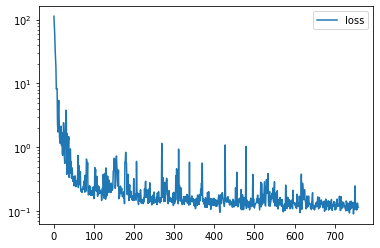

In [ ]:
epochs = 1
model = ThreeInputsNet()
model.to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss().to(device)

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):
        # Preprocessing the batch data and target
        
        title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        category = torch.tensor(batch["Categorical"], dtype=torch.float32, device=device)
        
        target = torch.tensor(target, device=device)

        predictions = model(title, desc, category)
        predictions = predictions.flatten()

        opt.zero_grad()
        # Compute loss.

        loss = criterion(predictions, target)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        opt.step()
        # Train with backprop.

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.yscale('log')
            plt.legend()
            plt.show()

In [ ]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in tqdm(data_iterator):
        
        title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        category = torch.tensor(batch["Categorical"], dtype=torch.float32, device=device)
        
        pred = model(title, desc, category)[:, 0].cpu().numpy()

        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")
    
    return squared_error / num_samples, abs_error / num_samples


train_errors = evaluate_model(model, data_train, name="Train")
test_errors = evaluate_model(model, data_val, name="Val")

0it [00:00, ?it/s]

Train:
MSE: 0.11243
MAE: 0.25484


0it [00:00, ?it/s]

Val:
MSE: 0.11965
MAE: 0.26394


In [ ]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in tqdm(data_iterator):
        
        title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        category = torch.tensor(batch["Categorical"], dtype=torch.float32, device=device)
        
        pred = model(title, desc, category)[:, 0].cpu().numpy()

        squared_error += np.sum(np.square(np.exp(pred) - np.exp(target)))
        abs_error += np.sum(np.abs(np.exp(pred) - np.exp(target)))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")
    
    return squared_error / num_samples, abs_error / num_samples


train_errors = evaluate_model(model, data_train, name="Train")
test_errors = evaluate_model(model, data_val, name="Val")

0it [00:00, ?it/s]

Train:
MSE: 171929688.19994
MAE: 8762.57302


0it [00:00, ?it/s]

Val:
MSE: 183495038.62467
MAE: 9110.68273


### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 
*Hint: try to build networks with ~same number of paremeters.*

*Used LSTM to encode Titles at __Bonus area 1__*

### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [20]:
# YOUR CODE HERE
data = pd.read_csv("Train_rev1.csv", index_col=None)

In [21]:
data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna("NaN")
data[text_columns] = data[text_columns].fillna("NaN")

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
93221,69188446,GRADUATE SALES EXECUTIVE / TRAINEE BUSINESS DE...,GRADUATE SALES EXECUTIVE / TRAINEE BUSINESS DE...,City London South East,London,NaN,NaN,BMS Sales Specialists LLP,Sales Jobs,"25000 per annum + 30% Bonus, Car, Mobile",25000,salestarget.co.uk,10.126671
143596,70622627,Senior Java Developer,My client are a leading software house and con...,Yorkshire Leeds LS1 8,Horsforth,NaN,permanent,The Bridge Ltd,IT Jobs,40000.00 - 50000.00 GBP Annual,45000,jobserve.com,10.714440
28108,67946379,Technical Director Strategic Modelling,Introduction An excellent opportunity to work ...,Woking,Woking,NaN,NaN,Matchtech Group plc.,Engineering Jobs,"58,000 - 65,000/yr",61500,rengineeringjobs.com,11.026809


In [22]:
tokenizer = WordPunctTokenizer()

def normalize(text):
    tokens = tokenizer.tokenize(text.lower())
    return ' '.join(tokens)
# Lowercase and tokenize titles and descriptions (text_columns).
# Store items as space-separated strings of tokens.
data[text_columns] = data[text_columns].applymap(normalize)

In [23]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

In [24]:
token_counts = Counter()
for row in data_train[text_columns].values.flatten():
    token_counts.update(row.split(' '))

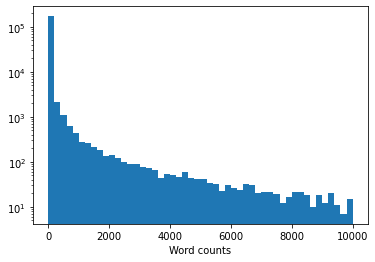

In [25]:
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

In [27]:
min_count = 10

# We shall only consider tokens that had at least min_count occurences.
# Create a list of such tokens.
tokens = [token for token, counts in token_counts.items() if counts >= min_count]

In [28]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 30715


In [29]:
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
UNK_IDX = token_to_idx[UNK]
PAD_IDX = token_to_idx[PAD]

In [30]:
company_counts = Counter(data_train["Company"])
top_companies = set(name for name, count in company_counts.most_common(1000))
data_train["Company"] = data_train["Company"].apply(
    lambda company: company if company in top_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data_train[categorical_columns].apply(dict, axis=1));

In [31]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(matrix, keep_prob, replace_with=UNK_IDX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prob, 1 - keep_prob])
    dropout_mask &= matrix != PAD_IDX
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [32]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

In [33]:
len(categorical_vectorizer.vocabulary_)

3579

In [34]:
class ThreeInputsNet(nn.Module):
    def __init__(
        self,
        n_tokens=len(tokens),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size=64,
    ):
        super().__init__()
        
        # Define modules to process the title.
        self.title_emb = nn.Embedding(n_tokens, hid_size)
        self.title_enc = nn.LSTM(hid_size, hid_size, 2, batch_first=True)
        
        # Define modules to process the description.
        self.desc_enc = nn.Sequential(
            nn.Embedding(n_tokens, hid_size),
            Reorder(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten()
        )
        
        # Define modules to process the categorical features.
        # self.category_out = ...
        self.cat_enc = nn.Sequential(
            nn.Linear(n_cat_features, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
        )

        self.out = nn.Linear(3 * hid_size, 1)
        
    def forward(self, title, desc, category):
        
        title_beg = self.title_emb(title)
        lstm_out, (title_enc, _) = self.title_enc(title_beg)
        
        assert torch.equal(lstm_out[:, -1],title_enc[-1])
        
        title_enc = title_enc[-1]

        desc_enc = self.desc_enc(desc)

        category_enc = self.cat_enc(category)
        
        #print(title_enc.shape, desc_enc.shape, category_enc.shape)
        
        concatenated = torch.cat(
            [
                title_enc.view(title_enc.size(0), -1),
                desc_enc.view(desc_enc.size(0), -1),
                category_enc.view(category_enc.size(0), -1),
            ],
            dim=1,
        )

        out = self.out(concatenated)

        return out

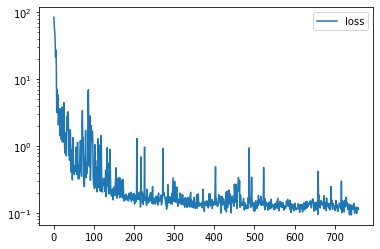

In [37]:
epochs = 1
model = ThreeInputsNet()
model.to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss().to(device)

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train, word_dropout=0.2):
        # Preprocessing the batch data and target
        
        title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        category = torch.tensor(batch["Categorical"], dtype=torch.float32, device=device)
        
        target = torch.tensor(target, device=device)

        predictions = model(title, desc, category)
        predictions = predictions.flatten()

        opt.zero_grad()
        # Compute loss.

        loss = criterion(predictions, target)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        opt.step()
        # Train with backprop.

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.yscale('log')
            plt.legend()
            plt.show()

In [38]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in tqdm(data_iterator):
        
        title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        category = torch.tensor(batch["Categorical"], dtype=torch.float32, device=device)
        
        pred = model(title, desc, category)[:, 0].cpu().numpy()

        squared_error += np.sum(np.square(np.exp(pred) - np.exp(target)))
        abs_error += np.sum(np.abs(np.exp(pred) - np.exp(target)))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")
    
    return squared_error / num_samples, abs_error / num_samples


train_errors = evaluate_model(model, data_train, name="Train")
test_errors = evaluate_model(model, data_val, name="Val")

0it [00:00, ?it/s]

Train:
MSE: 270671131.15393
MAE: 11879.92236


0it [00:00, ?it/s]

Val:
MSE: 292257295.16526
MAE: 12318.27666


__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)